In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [3]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os
import permute.core

%matplotlib inline
#matplotlib
#np.set_printoptions(suppress = True)

In [217]:
mac         = False
workstation = True
if workstation:
    os.chdir("/home/sammirc/Experiments/Nick/AttentionSaccade") #workstation directory
elif mac:
    os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade") #laptop directory


#sublist = [1,2,3,4,5,6,7,8,9]
sublist = [1,2,3,4,5,6,7,8,9,10,11,12,13]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

In [218]:
attn = data.loc[data['task']==1]
attn.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

In [219]:
corr_attn   = attn.query('corr == 1') # equivalent to dplyr::filter(attn, corr == 1)
incorr_attn = attn.query('corr == 0') # equivalent to dplyr::filter(attn, corr == 0)

In [220]:
attn = data.loc[data['task']==1]
df = attn.groupby(['subject', 'validity']).agg({'corr': ['mean', 'std'], 'time': ['mean', 'std']})
df.columns = ['_'.join(col) for col in df.columns]
df = df.reset_index();

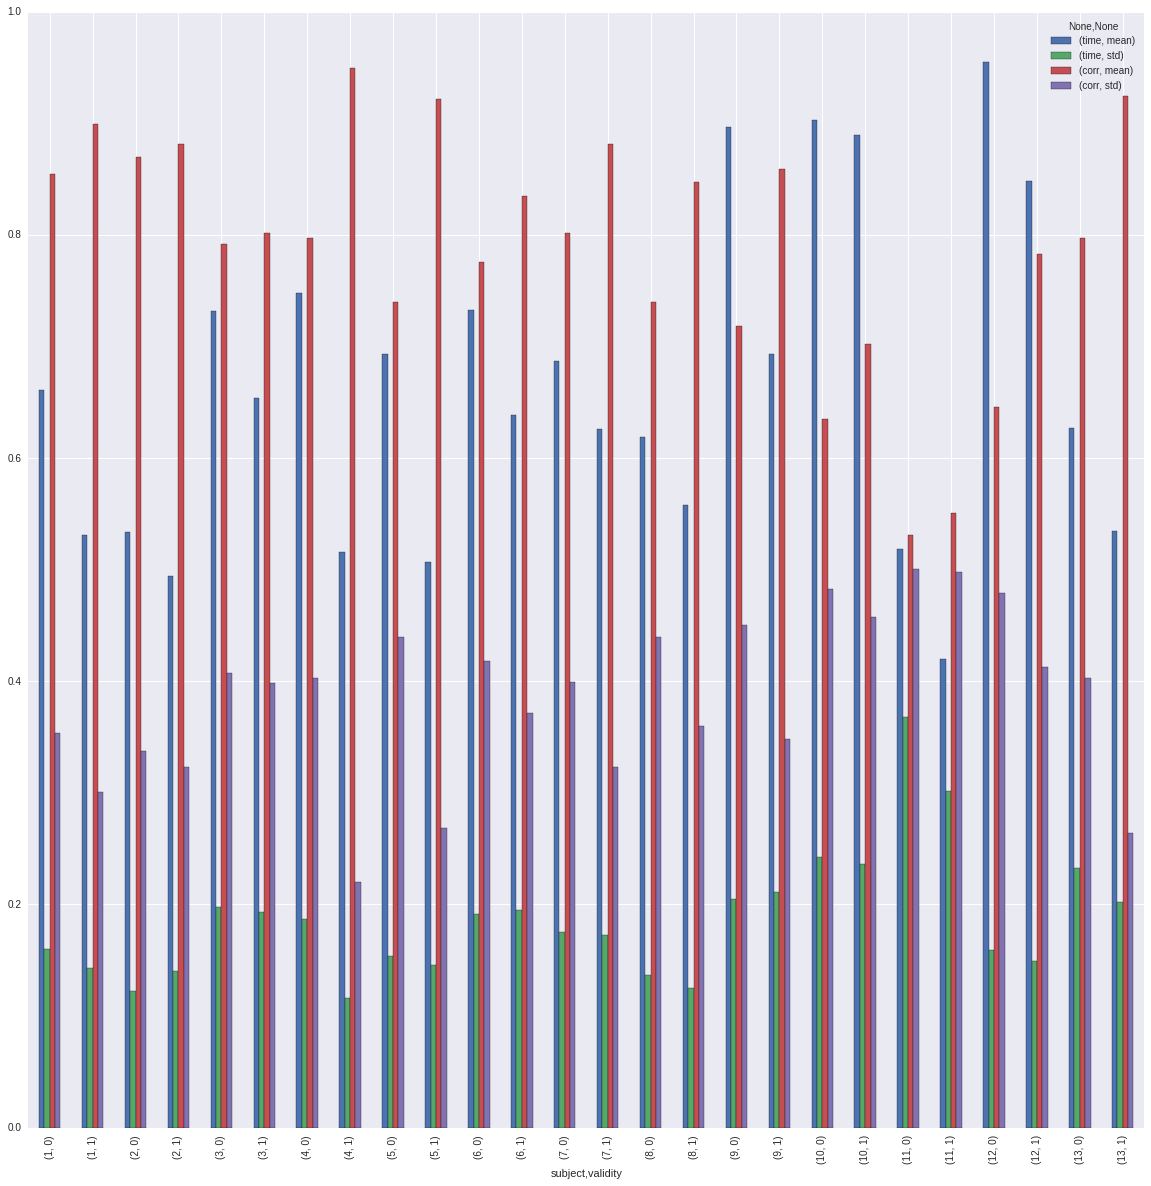

In [161]:
plt.rcParams['figure.figsize'] = (20,20)
df.plot(kind = 'bar', y = ['time', 'corr'])

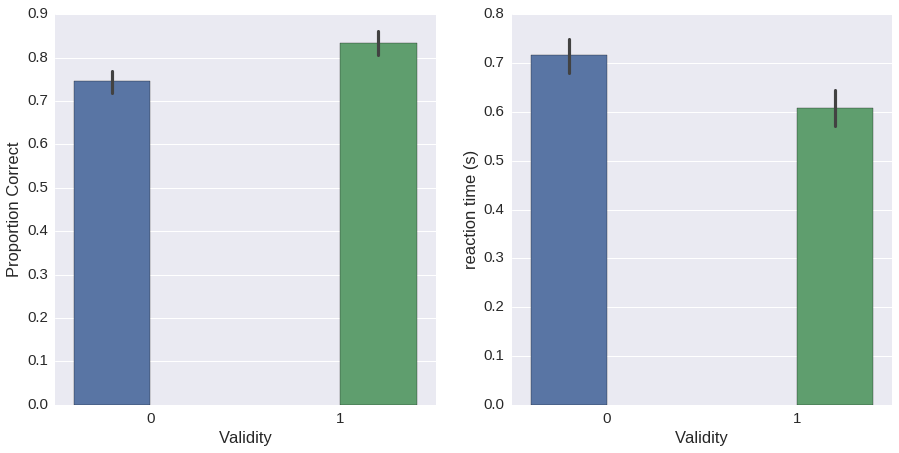

In [256]:
sns.set(style = 'darkgrid', font_scale=1.5, rc = {'figure.figsize':(15,7)})
f, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(data = df, x = 'validity', y = 'corr_mean', hue = 'validity', ci = 68, ax = ax1)
ax1.set_xlabel('Validity')
ax1.set_ylabel('Proportion Correct')
ax1.legend().set_visible(False)

sns.barplot(data = df, x = 'validity', y = 'time_mean', hue = 'validity', ci = 68, ax = ax2)
ax2.set_xlabel('Validity')
ax2.set_ylabel('reaction time (s)')
ax2.legend().set_visible(False)
#sns.despine()

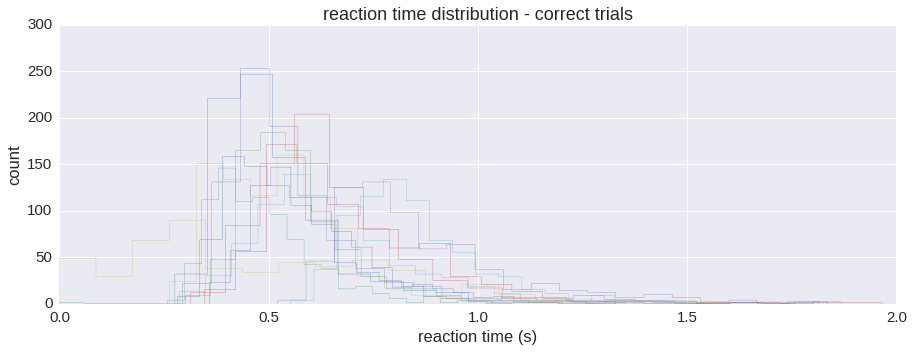

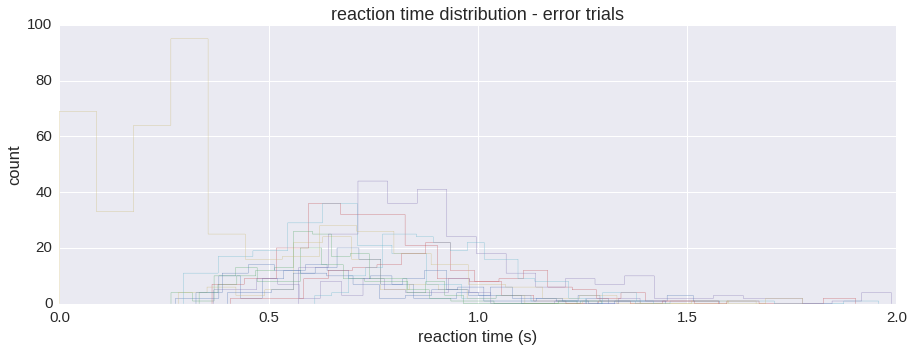

In [257]:
#plot response distribution for correct trials
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.loc[attention['corr']==1].groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')
plt.title('reaction time distribution - correct trials')
plt.xlabel('reaction time (s)'); plt.ylabel('count')

# plot response distribution for incorrect trials
plt.figure()
for i, subject in attention.loc[attention['corr']==0].groupby('subject'):
    subject.time.hist(bins=20, histtype = 'step')
plt.title('reaction time distribution - error trials')
plt.xlabel('reaction time (s)'); plt.ylabel('count')

In [21]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]
#rename coding of validity to string instead of number

attention.loc[attention.validity==1, 'validity'] = 'valid'
attention.loc[attention.validity==0, 'validity'] = 'invalid'

#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

In [22]:
#drift diffusion model on attention task data
if not os.path.exists(os.path.join(os.getcwd(),'fullDDM_attention.db')):
    model = hddm.HDDM(data= attention, p_outlier=0.05, bias = True, trace_subjs = True,
                 depends_on = {'v':'validity', # a (decision threshold) should be kept fixed across participants, unless a reason to assume it shouldn't be
                               't':'validity', 'z':'validity'}, # 'sv' prone to fit errors (see de Gee et al. eLife 2017) so fit across conditions to maximise fit
                 include = {'sv', 'a', 'v', 't', 'z'})
    model.find_starting_values()
    model.sample(2000, burn=20, dbname = 'fullDDM_attention.db', db = 'pickle')
    model.save('fullDDM_attention')
else:
    model = hddm.load('fullDDM_attention')
    
stats = model.gen_stats()
stats[stats.index.isin(['a', 'v(valid)', 'v(invalid)', 't(valid)', 't(invalid)', 'z(valid)', 'z(invalid)'])]

/home/sammirc/anaconda2/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2001 of 2000 complete in 201.5 sec

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.29416,0.0346154,1.22766,1.27137,1.29237,1.31634,1.36249,0.000999982
v(invalid),1.33231,0.226295,0.879893,1.1823,1.3368,1.48206,1.78138,0.00542084
v(valid),2.09549,0.219591,1.68054,1.95032,2.09049,2.2371,2.53702,0.00587805
t(invalid),0.422381,0.074625,0.291882,0.369195,0.418396,0.46815,0.578877,0.00341809
t(valid),0.350853,0.069561,0.231921,0.304374,0.344713,0.389421,0.512313,0.00345295
z(invalid),0.482589,0.0137277,0.455188,0.473299,0.482765,0.491804,0.509585,0.000605773
z(valid),0.452879,0.0115066,0.430533,0.445278,0.453117,0.460472,0.474969,0.000482736


In [ ]:
# read in/create model where all params except drift rate can vary across validity conditions
if not os.path.exists(os.path.join(os.getcwd(),'DDM_attention_fixDR.db')):
    model_fixDR = hddm.HDDM(data= attention, p_outlier=0.05, bias = True, trace_subjs = True,
                 depends_on = {#'v':'validity', #keep drift rate fixed across conditions to see effect of validity in model fit
                               't':'validity', 'z':'validity'}, # 'sv' prone to fit errors (see de Gee et al. eLife 2017) so fit across conditions to maximise fit
                 include = {'sv'})
    model_fixDR.find_starting_values()
    model_fixDR.sample(2000, burn=20, dbname = 'DDM_attention_fixDR.db', db = 'pickle')
    model_fixDR.save('DDM_attention_fixDR')
else:
    model_fixDR = hddm.load('DDM_attention_fixDR')
    
stats_fixDR = model_fixDR.gen_stats()
stats_fixDR[stats_fixDR.index.isin(['a', 'v', 't(valid)', 't(invalid)', 'z(valid)', 'z(invalid)'])]

In [ ]:
#diffusion model of attention data, all parameters fixed across conditions (not depending on validity)
if not os.path.exists(os.path.join(os.getcwd(), 'DDM_attention_fixed.db')):
    model_fixed = hddm.HDDM(data = attention, p_outlier = 0.05, trace_subjs = True, include = {'a','v','t','z', 'sv'})
    model_fixed.find_starting_values()
    model_fixed.sample(2000, burn = 20, dbname = 'DDM_attention_fixed.db', db='pickle')
    model_fixed.save('DDM_attention_fixed')
else:
    model_fixed = hddm.load('DDM_attention_fixed')

stats_fixed = model_fixed.gen_stats()
stats_fixed[stats_fixed.index.isin(['a', 'v', 't', 'z'])]

In [23]:
print 'full model (fixed DC) : ', model.dic_info
print 'model fixing DC and DR across validity: ', model_fixDR.dic_info
print 'model fixing all parameters across validity: ', model_fixed.dic_info

full model (fixed DC) :  {'deviance': 1504.0227108387535, 'pD': 77.333798706257767, 'DIC': 1581.3565095450112}
model fixing DC and DR across validity: 

NameError: name 'model_fixDR' is not defined

In [ ]:
model.plot_posterior_predictive(figsize = (20,20), samples = 100, bins = 50)

In [ ]:
model_fixed.plot_posterior_predictive(figsize=(20,20), samples = 100, bins = 50)

In [ ]:
model_fixDR.plot_posterior_predictive(figsize=(20,20), samples = 100, bins = 50)

/home/sammirc/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'verdana'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


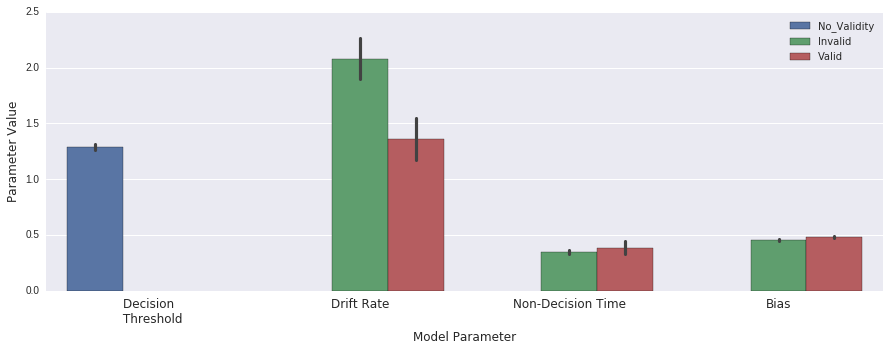

In [24]:
#subset model parameter statistics to single subject parameters for plotting
#indices = ['a(valid)' , 'a(invalid)' ,'a_std' , 'v(valid)' , 'v(invalid)' ,'v_std' ,
#           't(valid)' , 't(invalid)' ,'t_std' , 'z(valid)' , 'z(invalid)' ,'z_std', 'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)']
indices = ['a' , 'a_std',
           'v(valid)' , 'v(invalid)', 'v_std',
           't(valid)' , 't(invalid)', 't_std',
           'z(valid)' , 'z(invalid)', 'z_std',
           'sv'] #variables to drop (i.e. only keep subject parameter estimates!)
plotsub_stats = pd.DataFrame(stats)
plotsub_stats = stats.drop(indices); plotsub_stats = pd.DataFrame(plotsub_stats.loc[:,'mean'])
# 7 variables now (a, t(valid), t(invalid), v(valid), v(invalid), z(valid), z(invalid) ) with 9 subs
paramnum = 7

plotsub_stats['modelparam'] = np.sort(np.tile(range(1,paramnum+1), len(sublist)))
plotsub_stats['validity'] = np.concatenate([np.zeros(len(sublist)), np.tile(np.concatenate([np.ones(len(sublist)), np.add(np.ones(len(sublist)),1)]),paramnum/2)])
plotsub_stats['subject'] = np.tile(np.arange(1,len(sublist)+1), paramnum)

plotsub_stats.loc[plotsub_stats.modelparam ==1, 'modelparam'] = 'a';
plotsub_stats.loc[plotsub_stats.modelparam.isin([2,3]), 'modelparam'] = 't'
plotsub_stats.loc[plotsub_stats.modelparam.isin([4,5]), 'modelparam'] = 'v'
plotsub_stats.loc[plotsub_stats.modelparam.isin([6,7]), 'modelparam'] = 'z'

plotsub_stats.loc[plotsub_stats.validity==1, 'validity'] = 'Invalid'
plotsub_stats.loc[plotsub_stats.validity==2, 'validity'] = 'Valid'
plotsub_stats.loc[plotsub_stats.validity==0, 'validity'] = 'No_Validity'
#visualise parameter estimates by validity
ax = sns.barplot(data = plotsub_stats, x = 'modelparam', hue = 'validity', y = 'mean', ci = 68) #ci = 68 plots standard error of mean

ax.set_xticklabels(['Decision \n Threshold', 'Drift Rate', 'Non-Decision Time', 'Bias'], {'size':12, 'name':'verdana'})
ax.set_ylabel('Parameter Value',{'size':12, 'name':'verdana'}); ax.set_xlabel('Model Parameter',{'size':12, 'name':'verdana'})
ax.legend(prop = {'size':10, 'family':'verdana'})
plt.rcParams['figure.figsize'] = (10,10)
plt.savefig(os.path.join(os.getcwd(), 'figures', 'modelparameter_barplot_9subs.pdf'))
#plt.close()

In [26]:
params_of_interest_i  = ['v(invalid)', 't(invalid)', 'z(invalid)']
params_of_interest_v  = ['v(valid)'  , 't(valid)'  , 'z(valid)']
params_of_interest_is = ['v_subj(invalid)', 't_subj(invalid)', 'z_subj(invalid)']
params_of_interest_vs = ['v_subj(valid)'  , 't_subj(valid)'  , 'z_subj(valid)']

params_v = []
params_i = []
ind = np.ones(len(sublist), dtype=bool)

for p in range(len(params_of_interest_vs)):
    params_v.append(np.array([stats.lookup(['{}.'.format(params_of_interest_vs[p]) + str(s)], ['mean']) for s in sublist])[ind].ravel())
    params_i.append(np.array([stats.lookup(['{}.'.format(params_of_interest_is[p]) + str(s)], ['mean']) for s in sublist])[ind].ravel())

param_names = ['v', 't', 'z']
parameters = pd.concat((pd.DataFrame(np.vstack(params_v).T, columns = param_names), pd.DataFrame(np.vstack(params_i).T, columns=param_names))) 
parameters['validity'] = np.concatenate([np.ones(len(sublist)), np.zeros(len(sublist))])
parameters['subject']  = np.concatenate([sublist, sublist])

In [27]:
#permutation test on DDM parameters
permtest_dr = permute.core.one_sample(parameters['v'][parameters.validity==1.0], parameters['v'][parameters.validity==0.0], alternative='two-sided')
permtest_ndt = permute.core.one_sample(parameters['t'][parameters.validity==1.0], parameters['t'][parameters.validity==0.0], alternative='two-sided')
print permtest_dr, '\n', permtest_ndt #output is p-value first, then difference in means

(0.00018000000000000001, 0.77064593948771942) 
(0.00039999999999995595, -0.078122362354948058)


Plotting a
Plotting v(invalid)
Plotting v(valid)
Plotting t(invalid)
Plotting t(valid)


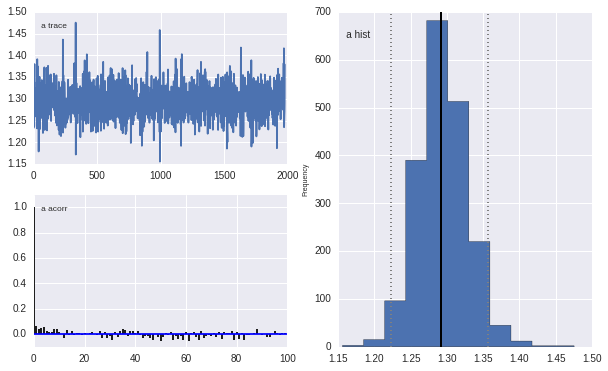

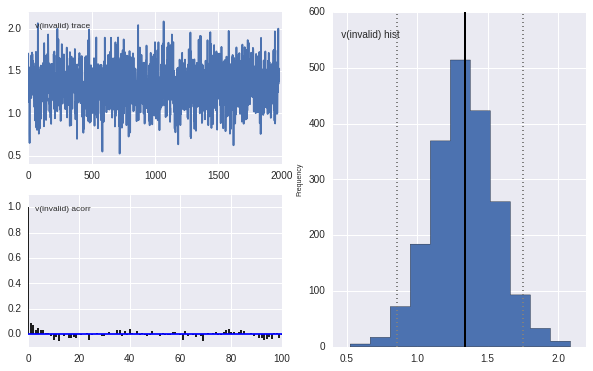

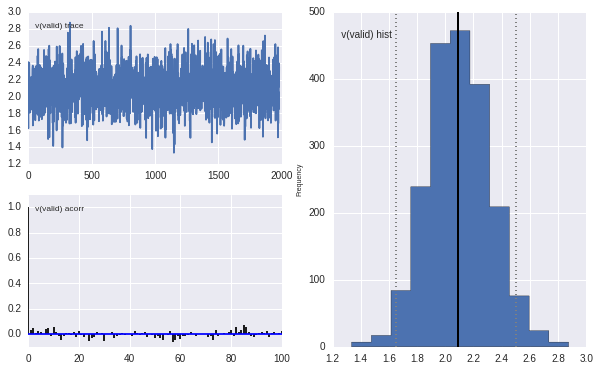

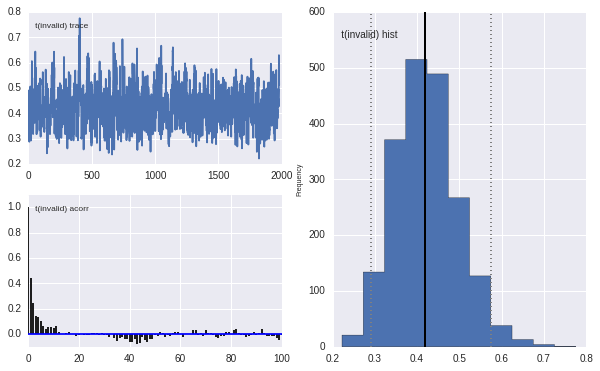

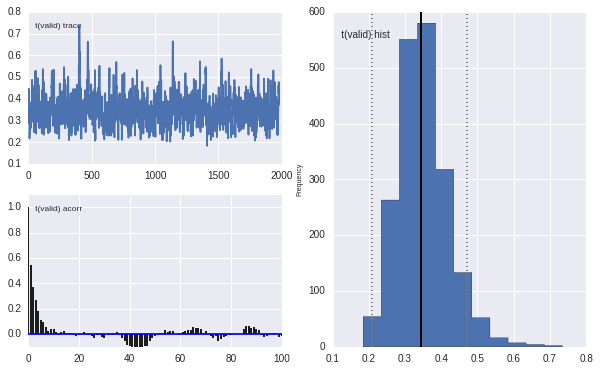

In [28]:
plt.rcParams['figure.figsize'] = (5,5)
# visually check that mcmc chains have converged
model.plot_posteriors(['a', 'v', 't'])

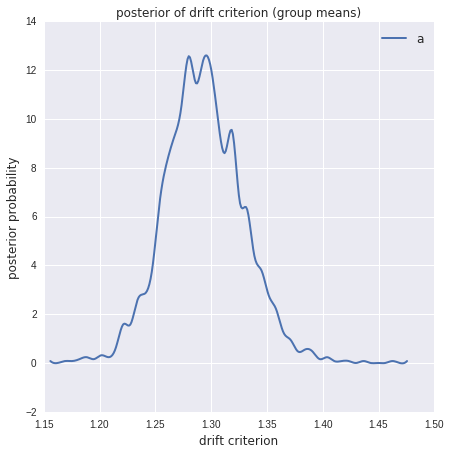

In [29]:
plt.rcParams['figure.figsize'] = (7,7)
a, v_valid, v_invalid, t_valid, t_invalid = model.nodes_db.node[['a','v(valid)', 'v(invalid)','t(valid)', 't(invalid)']]

#plot posterior nodes for parameters by validity
hddm.analyze.plot_posterior_nodes([a]) #decision criterion
plt.ylabel('posterior probability', {'size':12, 'name':'verdana'})
plt.xlabel('drift criterion', {'size':12, 'name':'verdana'})
plt.title('posterior of drift criterion (group means)', {'size':12, 'name':'verdana'})
plt.legend(prop={'size':12, 'family':'verdana'})
plt.savefig('./figures/posterior_driftcriterion_groupmeans.pdf')

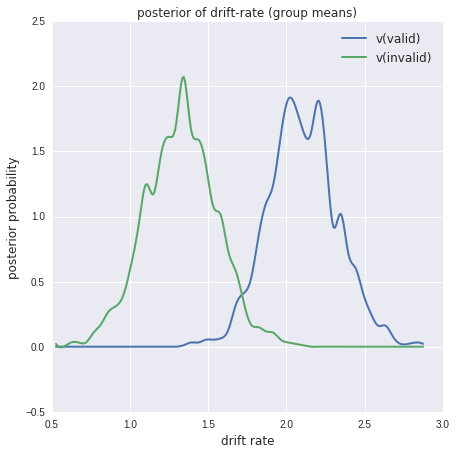

In [30]:
#plot drift rate posterior distribution
plt.rcParams['figure.figsize'] = (7,7)
hddm.analyze.plot_posterior_nodes([v_valid, v_invalid])
plt.ylabel('posterior probability', {'size':12, 'name':'verdana'})
plt.xlabel('drift rate', {'size':12, 'name':'verdana'})
plt.title('posterior of drift-rate (group means)', {'size':12, 'name':'verdana'})
plt.legend(prop={'size':12, 'family':'verdana'})
plt.savefig('./figures/posterior_driftrate_groupmeans.pdf')

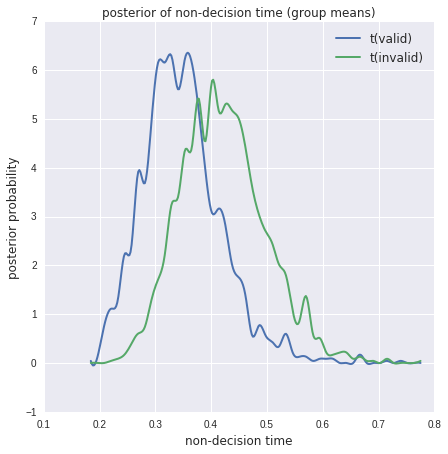

In [32]:
#plot drift rate posterior distribution
plt.rcParams['figure.figsize'] = (7,7)
hddm.analyze.plot_posterior_nodes([t_valid, t_invalid])
plt.ylabel('posterior probability', {'size':12, 'name':'verdana'})
plt.xlabel('non-decision time', {'size':12, 'name':'verdana'})
plt.title('posterior of non-decision time (group means)', {'size':12, 'name':'verdana'})
plt.legend(prop={'size':12, 'family':'verdana'})
plt.savefig('./figures/posterior_nondecisiontime_groupmeans.pdf')

In [ ]:
model_nocond = hddm.HDDM(data=attention, p_outlier=0.05, bias = True, trace_subjs = True, include = {'a', 't', 'v', 'z', 'sv'})
model_nocond.find_starting_values()
model_nocond.sample(2000, burn=20, dbname = 'DDM_attention_NoValidityGrouping.db', db = 'pickle')
model_nocond.save('DDM_attention_NoValidityGrouping')

print 'full model no validity: ', model_nocond.dic_info
print 'full model: ', model.dic_info
print 'fixed drift rate model: ', model_fixDR.dic_info

In [ ]:
# comparison of hierarchical models is done using DIC (deviance information criterion) -- lower DIC indicates better fit
# compare models where all parameters are estimated